In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
# set plot style
plt.style.use('ggplot')

In [3]:
# import data
pp_data = pd.read_csv("../data/pp_data_2018_processed.csv")
pp_duration = pd.read_csv("../data/pp_duration_2018_processed.csv")

In [4]:
pp_data.head()

,age,sex,height_in,start_weight,end_weight,weight_diff,score,num_comments,month,dayofweek,NSFW,num_posts
0,22.0,0,75.0,290.0,185.0,105.0,246.0,10.0,1.0,5.0,0.0,1.0
1,27.0,1,70.0,355.0,340.0,15.0,576.0,31.0,1.0,5.0,0.0,12.0
2,23.0,1,60.0,260.0,218.0,42.0,210.0,5.0,1.0,5.0,0.0,1.0
3,24.0,1,63.0,160.0,135.0,25.0,1.0,1.0,1.0,5.0,0.0,1.0
4,48.0,1,66.0,326.0,180.0,146.0,3163.0,144.0,1.0,5.0,0.0,15.0


In [5]:
pp_duration.head()

,age,sex,height_in,start_weight,end_weight,weight_diff,score,num_comments,month,dayofweek,NSFW,num_posts,period_months,rate,norm_rate
0,22.0,0,75.0,290.0,185.0,105.0,246.0,10.0,1.0,5.0,0.0,1.0,24.0,4.375000,0.015086
1,27.0,1,70.0,355.0,340.0,15.0,576.0,31.0,1.0,5.0,0.0,12.0,1.0,15.000000,0.042254
2,23.0,1,60.0,260.0,218.0,42.0,210.0,5.0,1.0,5.0,0.0,1.0,12.0,3.500000,0.013462
3,24.0,1,63.0,160.0,135.0,25.0,1.0,1.0,1.0,5.0,0.0,1.0,6.0,4.166667,0.026042
4,48.0,1,66.0,326.0,180.0,146.0,3163.0,144.0,1.0,5.0,0.0,15.0,101.0,1.445545,0.004434


### Functions for regression analysis

In [6]:
# simple linear regression
def linear_regression(y, df, exclude):
    """Generates a simple linear regression model for the provided dependent variable and each independent variable 
    in the provided dataframe, but not included in the exclude list.  Prints the summary of each model and returns a 
    dataframe containing model information. 
    
    Arguments:
    y -- column name of the dependent variable; provide a string
    df -- Pandas dataframe that contains the data for the dependent and independent variables; provide a df
    exclude --  column name(s) to be excluded from the analysis; provide a list of strings or an empty list if
        there are no columns to exclude
        
    Returns:
    results_df -- Pandas dataframe that contains information about each model generated including the F-statistic, F-statistic 
    p-value, t-test, t-test p-value, and R-squared value.
    """
    exclude_cols = []
    results = {}
    exclude_cols.append(y)
    exclude_cols.extend(exclude)
    print('y =', y)
    print("excluded features:", exclude_cols)
    print("df shape:", df.shape)
    features = [col for col in df.columns if col not in exclude_cols]
    for f in features:
        str1 = "{0} ~ {1}".format(y, f)
        reg_model = sm.OLS.from_formula(str1, df).fit()
        results[f] = [round(reg_model.rsquared, 3), round(reg_model.fvalue, 1), round(reg_model.f_pvalue, 4), 
                     round(reg_model.tvalues[1], 2), round(reg_model.pvalues[1], 4)]
        print('X =', f.upper())
        print(reg_model.summary())
        print('')  
    results_df = pd.DataFrame.from_dict(results, columns=["R-sqr", "F-statistic", "F-stat p-value", 't-test',
                                                          't-test p-value'], orient='index')
    return results_df.sort_values("R-sqr", ascending=False)

In [7]:
# diagnostic plots for a simple linear regression
def lin_regr_diagnostic_plots(y, x, df):
    """Generates diagnostic plots used to evaluate a simple linear regression model. The plots include a scatter plot 
    of the independent variable vs the dependent variable to evaluate linearity, a scatter plot of the standardized
    residuals vs fitted values to evaluate error variance, and a probability plot to evaluate error normality. 
    
    Arguments:
    y -- column name of the dependent variable; provide a string
    x -- column name of the independent variable; provide a string
    df -- Pandas dataframe that contains the data for the dependent and independent variables; provide a df
        
    Returns:
    None 
    """
    str1 = "{0} ~ {1}".format(y, x)
    reg_model = sm.OLS.from_formula(str1, df).fit()
    fit_values = pd.Series(reg_model.fittedvalues, name="fitted_values")
    residuals = pd.Series(reg_model.resid, name="residuals")
    norm_residuals = pd.Series(reg_model.get_influence().resid_studentized_internal, name="Standardized Residual")
                                                              
    fig = plt.figure(constrained_layout=True, figsize=(8,8))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("Regression plot")
    sns.regplot(x, y, df, line_kws={'color':'r'}, ci=None, ax=ax1)
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_title("Standardized residuals vs Fit plot")
    sns.regplot(fit_values, norm_residuals, line_kws={'color':'r'}, ci=None, ax=ax2)
    ax3 = fig.add_subplot(gs[0:, -1])
    sp.stats.probplot(norm_residuals, plot=ax3, fit=True)
    fig.suptitle('y = {}, x = {}'.format(y, x, df), fontsize=14)
    
    return fig

In [8]:
# These functions implement the "best subsets" regression procedure

def process_subset(y, feature_set, df):
    """Generates a linear regression model and returns the number of independent variables it contains, the 
    names of the independent variables, the model, and the model's RSS value, R-squared value, and R-squared-adjusted
    value.
    """
    str1 = str(y) + ' ~ ' + ' + '.join(list(feature_set))
    model = sm.OLS.from_formula(str1, df)
    regr = model.fit()
    RSS = ((regr.predict(df[list(feature_set)]) - df[y]) ** 2).sum()
    R_squared = regr.rsquared
    R_squared_adj = regr.rsquared_adj
    return {"num_predictors": len(feature_set), "predictors": feature_set, "RSS": RSS, "rsquared": R_squared, "rsquared_adj": R_squared_adj, "model":regr}

def get_best(y, df, features, k):
    """Generates all possible combinations of independent variables, generates linear regression models using the
    variable combinations and returns those with the highest R-squared-adjusted values.
    """
    results = []
    for combo in itertools.combinations(features, k):
        #print("combo:", combo)
        inv_results = process_subset(y, combo, df)
        #print("results:", inv_results["rsquared_adj"])
        results.append(inv_results)
    models = pd.DataFrame(results)
    best_model = models.nlargest(2, "rsquared_adj")
    #print("Best model", best_model)
    return best_model

def subset_linear_regression(y, df, exclude):
    """Generates regression models using all possible combinations of independent variables, then chooses the models 
    with the highest R-squared-adj values. 
    
    Arguments:
    y -- column name of the dependent variable; provide a string
    df -- Pandas dataframe that contains the data for the dependent and independent variables; provide a df
    exclude --  column name(s) to be excluded from the analysis; provide a list of strings or an empty list if
        there are no columns to exclude
        
    Returns:
    models -- Pandas dataframe that contains information about the two (or one) model(s) with the highest R-squared adj
    value from the independent variable combinations.  For example, if there are 4 independent variables, the function 
    will return the two models with the highest R-squared-adj. value if one, two, and three independent variables are 
    included as well as the single model that contains four predictors. The returned information includes the number of 
    independent variables, the names of the independent variables, the model, and the model's RSS value, 
    R-squared value, and R-squared-adjusted value.
    """
    models = pd.DataFrame(columns=["num_predictors", "predictors", "RSS", "rsquared", "rsquared_adj", "model"])
    exclude_cols = []
    exclude_cols.append(y)
    exclude_cols.extend(exclude)
    features = [f for f in df.columns if f not in exclude_cols]
    for i in range(1, len(features)):
        #print("i:", i)
        models = pd.concat([models, get_best(y, df, features, i)], sort=True)
    return models

In [9]:
# These functions implement the "forward stepwise" regression procedure

def process_subset_ttest(y, feature_set, df):
    """Generates a linear regression model and returns the t-test p-values for all the included independent variables.
    """
    str1 = str(y) + ' ~ ' + ' + '.join(list(feature_set))
    model = sm.OLS.from_formula(str1, df)
    regr = model.fit()
    summary = regr.summary().tables[1]
    pvals = regr.pvalues
    results_series = pd.Series(pvals)
    #print(results_series)
    return results_series

def process_best_model(y, feature_set, df):
    """Generates a linear regression model and returns the number of independent variables it contains, the 
    names of the independent variables, the model, and the model's RSS value, R-squared value, and R-squared-adjusted
    value.
    """
    str1 = str(y) + ' ~ ' + ' + '.join(list(feature_set))
    model = sm.OLS.from_formula(str1, df)
    regr = model.fit()
    RSS = ((regr.predict(df[list(feature_set)]) - df[y]) ** 2).sum()
    R_squared = regr.rsquared
    R_squared_adj = regr.rsquared_adj
    return {"num_predictors": len(feature_set), "predictors": feature_set, "RSS": RSS, "rsquared": R_squared, "rsquared_adj": R_squared_adj, "model":regr}   

def forward_stepwise(y, predictors, y_and_exclude, df):
    """Takes the existing regression model and adds each remaining independent variable to it one at a time.  Compares
    the t-test p-values of new models and identifies the lowest t-test p-value.  If all variables are below the 
    0.15 signficance level, the included predictors are returned.  If the t-test p-values any of the previously 
    included variables now fall below the 0.15 level, they are removed and the remaining predictors are returned.
    """
    remaining_predictors = [p for p in df.columns if p not in predictors and p not in y_and_exclude]
    #print("remaining predictors: ", remaining_predictors)
    results = []
    for p in remaining_predictors:
        #print("p:", p)
        results.append(process_subset_ttest(y, (predictors + [p]), df)) # results is a list of pd Series
    #print("results:", results)
    low_pvalue = 0.15
    index_of_best_series = False
    new_predictors = []
    count = 0
    for i in range(len(results)):
        #print("i", i)
        #print("last value:", results[i][-1].item())
        current = results[i][-1].item()
        if current < 0.15:
            count =+ 1
            if current < low_pvalue:
                low_pvalue = current
                index_best_series = i
    if count == 0:
        for index, value in results[0][:-1].iteritems():
            #print("count = 0, index:", index, "value:", value)
            if index != "Intercept":
                new_predictors.append(index) 
        return(new_predictors)        
    for index, value in results[index_best_series].iteritems():
        #print("index:", index, "value:", value)
        if index != "Intercept":
            if value < 0.15:
                new_predictors.append(index)
    #print("new_predictors:", new_predictors)
    return(new_predictors) 

def stepwise_linear_regression(y, df, exclude):
    """First, individually evaluates independent variables in a linear regression model. The independent variable with 
    the lowest t-test p-value becomes the starting model.  Then the remainder of the independent variables are 
    individually added to the starting model.  If none have a significant t-test p-value then the process ends, but
    if one or many do, the one with the lowest t-test p-value is retained and a new starting model is established (after 
    it is determined that the original independent variable still has a significant t-test p-value).  This process is 
    repeated until no newly added independent variablies have a significant t-test p-value.  The best model from each 
    step is returned. 
    
    Arguments:
    y -- column name of the dependent variable; provide a string
    df -- Pandas dataframe that contains the data for the dependent and independent variables; provide a df
    exclude --  column name(s) to be excluded from the analysis; provide a list of strings or an empty list if
        there are no columns to exclude
        
    Returns:
    models_step -- Pandas dataframe that contains information about best model identified at each step of the process.
    The returned information includes the number of independent variables, the names of the independent variables, the 
    model, and the model's RSS value, R-squared value, and R-squared-adjusted value.
    """
    y_and_exclude = []
    y_and_exclude.append(y)
    y_and_exclude.extend(exclude)
    dep_var = df.shape[1] - len(y_and_exclude)
    #print(dep_var)
    old_predictors = []
    step = 0
    best_models = []
    new_predictors = forward_stepwise(y, old_predictors, y_and_exclude, df)
    best_predictors = [new_predictors]
    #print("1st comparision:", old_predictors, new_predictors)
    while old_predictors != new_predictors:
        step += 1
        #print("step", step)
        old_predictors = new_predictors
        #print('old_predictors:', old_predictors)
        if len(old_predictors) == dep_var:
            break
        new_predictors = forward_stepwise(y, old_predictors, y_and_exclude, df)
        #print('new_predictors:', new_predictors)
        best_predictors.append(new_predictors)
    #print("best_predictors:", best_predictors)    
    for predictor_list in best_predictors[:-1]:
        #print("predictor_list:", predictor_list)
        if predictor_list[-1] == None:
            pass
        else:
            best_models.append(process_best_model(y, predictor_list, df))    
    models_step = pd.DataFrame(best_models)
    return models_step

## Regression analysis

### Dependent variable = weight_diff (not included in final script or report)

Exclude features related to the r/progessusers post itself such as 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'

Use both the pp_data and pp_duration datasets

In [10]:
# simple linear regression
weight_diff = linear_regression("weight_diff", pp_data, ['score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

y = weight_diff
excluded features: ['weight_diff', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts']
df shape: (20065, 12)
X = AGE
                            OLS Regression Results                            
Dep. Variable:            weight_diff   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     964.2
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          8.25e-207
Time:                        11:39:24   Log-Likelihood:            -1.0433e+05
No. Observations:               20065   AIC:                         2.087e+05
Df Residuals:                   20063   BIC:                         2.087e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

In [11]:
weight_diff 

,R-sqr,F-statistic,F-stat p-value,t-test,t-test p-value
start_weight,0.603,30486.0,0.0,174.60,0.0
age,0.046,964.2,0.0,31.05,0.0
end_weight,0.045,947.9,0.0,30.79,0.0
height_in,0.012,243.1,0.0,15.59,0.0
sex,0.003,53.7,0.0,-7.33,0.0


Start weight is by far the best variable to explain variability in weight_diff.  

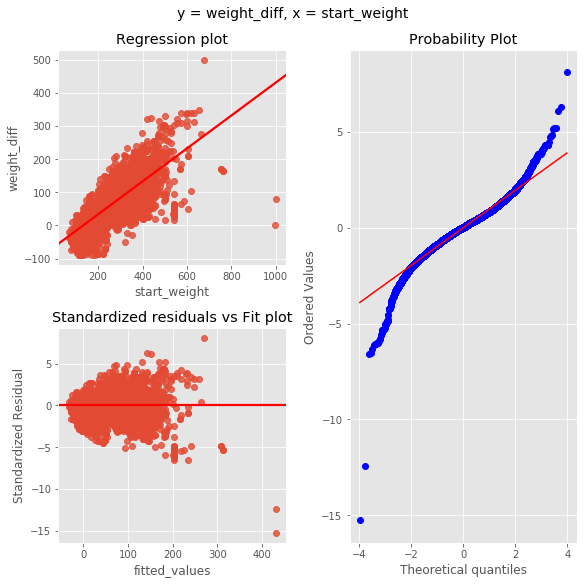

In [12]:
# diagnositic plots for start_weight
fig = lin_regr_diagnostic_plots("weight_diff", "start_weight", pp_data)

The regression plot shows a linear relationship between weight_diff and start weight.  The residuals vs fit plot looks pretty good with only a little fanning and the normality plot shows a normal distribution with heavy tails. 

In [13]:
# simple linear regression
weight_diff_dur = linear_regression("weight_diff", pp_duration, ['norm_rate', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts', 'norm_rate'])

y = weight_diff
excluded features: ['weight_diff', 'norm_rate', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts', 'norm_rate']
df shape: (12517, 15)
X = AGE
                            OLS Regression Results                            
Dep. Variable:            weight_diff   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     608.6
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          3.07e-131
Time:                        11:39:29   Log-Likelihood:                -65192.
No. Observations:               12517   AIC:                         1.304e+05
Df Residuals:                   12515   BIC:                         1.304e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err   

In [14]:
weight_diff_dur

,R-sqr,F-statistic,F-stat p-value,t-test,t-test p-value
start_weight,0.633,21560.0,0.0,146.83,0.0
rate,0.256,4300.6,0.0,65.58,0.0
end_weight,0.053,699.9,0.0,26.46,0.0
age,0.046,608.6,0.0,24.67,0.0
period_months,0.020,250.3,0.0,15.82,0.0
height_in,0.012,153.5,0.0,12.39,0.0
sex,0.002,29.7,0.0,-5.45,0.0


Again, start_weight is the best feature in this regression analysis, with rate being the second best. 

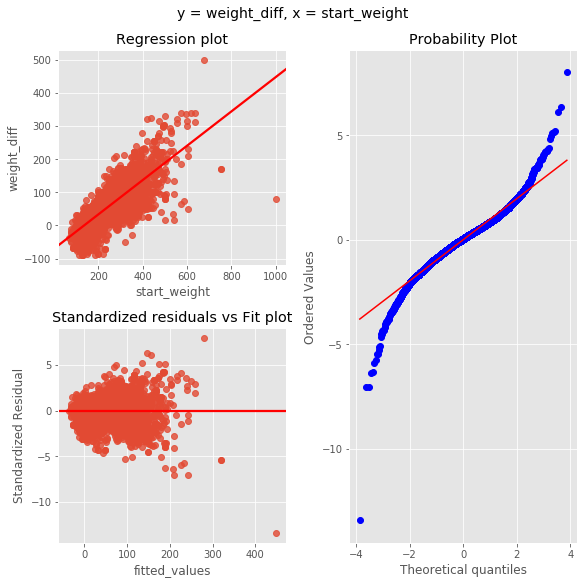

In [15]:
# diagnositic plots for the best two features
fig = lin_regr_diagnostic_plots("weight_diff", "start_weight", pp_duration)

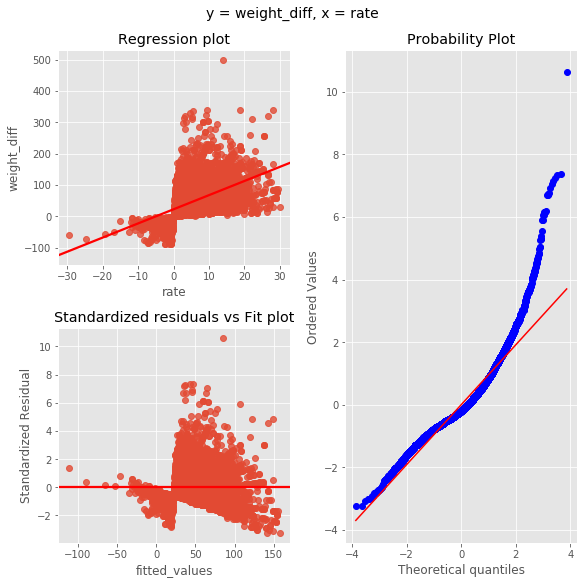

In [16]:
fig = lin_regr_diagnostic_plots("weight_diff", "rate", pp_duration)

The start_weight feature plots with the pp_duration dataset look very similar to how they looked with the pp_data dataset.  The rate feature plots are harder to interpret due to the abrupt transition from negiative to positive numbers.  The relationship looks linear and residuals are mostly normal except for a long tail.  I'm not sure how to interpret the residuals vs fit plot. 

In [17]:
# forward stepwise multiple linear regression with pp_data
# including end_weight allows the model to make a 100% prediction (of course!) so leave it out 
weight_diff_step = stepwise_linear_regression("weight_diff", pp_data, ['end_weight', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

In [18]:
weight_diff_step

,num_predictors,predictors,RSS,rsquared,rsquared_adj,model
0,1,[start_weight],1.604407e+07,0.603098,0.603078,<statsmodels.regression.linear_model.Regressio...
1,2,"[start_weight, height_in]",1.438790e+07,0.644069,0.644033,<statsmodels.regression.linear_model.Regressio...
2,3,"[start_weight, height_in, sex]",1.436347e+07,0.644673,0.644620,<statsmodels.regression.linear_model.Regressio...


In [19]:
# best subsets multiple linear regression with pp_data
weight_diff_subset = subset_linear_regression("weight_diff", pp_data, ['end_weight', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

In [20]:
weight_diff_subset

,RSS,model,num_predictors,predictors,rsquared,rsquared_adj
3,1.604407e+07,<statsmodels.regression.linear_model.Regressio...,1,"(start_weight,)",0.603098,0.603078
0,3.856959e+07,<statsmodels.regression.linear_model.Regressio...,1,"(age,)",0.045856,0.045809
5,1.438790e+07,<statsmodels.regression.linear_model.Regressio...,2,"(height_in, start_weight)",0.644069,0.644033
4,1.506729e+07,<statsmodels.regression.linear_model.Regressio...,2,"(sex, start_weight)",0.627262,0.627225
3,1.436347e+07,<statsmodels.regression.linear_model.Regressio...,3,"(sex, height_in, start_weight)",0.644673,0.644620
2,1.438745e+07,<statsmodels.regression.linear_model.Regressio...,3,"(age, height_in, start_weight)",0.644080,0.644027


Adding new variables does not markedly imporve the performance of the start_weight variable alone.  Adding height_in ups the R-squared adj around 4 points. 

In [21]:
# forward stepwise multiple linear regression with pp_duration
weight_diff_dur_step = stepwise_linear_regression("weight_diff", pp_duration, ['end_weight', 'norm_rate', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

In [22]:
weight_diff_dur_step

,num_predictors,predictors,RSS,rsquared,rsquared_adj,model
0,1,[start_weight],9.430228e+06,0.632722,0.632692,<statsmodels.regression.linear_model.Regressio...
1,2,"[start_weight, height_in]",8.392955e+06,0.673120,0.673068,<statsmodels.regression.linear_model.Regressio...
2,3,"[start_weight, height_in, period_months]",8.227875e+06,0.679550,0.679473,<statsmodels.regression.linear_model.Regressio...
3,4,"[start_weight, height_in, period_months, rate]",7.844999e+06,0.694461,0.694364,<statsmodels.regression.linear_model.Regressio...
4,5,"[start_weight, height_in, period_months, rate,...",7.831162e+06,0.695000,0.694878,<statsmodels.regression.linear_model.Regressio...


In [23]:
# best subsets multiple linear regression with pp_duration
weight_diff_dur_subsets = subset_linear_regression("weight_diff", pp_duration, ['end_weight', 'norm_rate', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

In [24]:
weight_diff_dur_subsets

,RSS,model,num_predictors,predictors,rsquared,rsquared_adj
3,9.430228e+06,<statsmodels.regression.linear_model.Regressio...,1,"(start_weight,)",0.632722,0.632692
5,1.910930e+07,<statsmodels.regression.linear_model.Regressio...,1,"(rate,)",0.255752,0.255692
9,8.392955e+06,<statsmodels.regression.linear_model.Regressio...,2,"(height_in, start_weight)",0.673120,0.673068
6,8.806263e+06,<statsmodels.regression.linear_model.Regressio...,2,"(sex, start_weight)",0.657023,0.656968
16,8.227875e+06,<statsmodels.regression.linear_model.Regressio...,3,"(height_in, start_weight, period_months)",0.679550,0.679473
17,8.271068e+06,<statsmodels.regression.linear_model.Regressio...,3,"(height_in, start_weight, rate)",0.677867,0.677790
14,7.844999e+06,<statsmodels.regression.linear_model.Regressio...,4,"(height_in, start_weight, period_months, rate)",0.694461,0.694364
13,8.178702e+06,<statsmodels.regression.linear_model.Regressio...,4,"(sex, start_weight, period_months, rate)",0.681465,0.681363
5,7.831162e+06,<statsmodels.regression.linear_model.Regressio...,5,"(sex, height_in, start_weight, period_months, ...",0.695000,0.694878
4,7.842985e+06,<statsmodels.regression.linear_model.Regressio...,5,"(age, height_in, start_weight, period_months, ...",0.694540,0.694418


I was suprised that a model including start_weight, period_months, and rate did not give a rsquared adjusted with 100% accuracy since the end weight can be calculated with those numbers.  This points out that the scraping of info from the title is not perfect.  I suspect the issue mostly falls with the duration of weight loss value. 

Like with pp_data, start_weight along seems to produce the most robust model. 

### Dependent variable = weight_diff
Exclude features related to the r/progessusers post itself such as 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'

Use only records from pp_data and pp_duration where people lost weight 

In [25]:
# filtering for datasets that only contain people who lost weight
pp_data_loss = pp_data[pp_data["weight_diff"] > 0]
pp_duration_loss = pp_duration[pp_duration["weight_diff"] > 0]

In [26]:
# simple linear regression with pp_data_loss
weight_diff_loss = linear_regression("weight_diff", pp_data_loss, ['score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

y = weight_diff
excluded features: ['weight_diff', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts']
df shape: (18083, 12)
X = AGE
                            OLS Regression Results                            
Dep. Variable:            weight_diff   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     549.3
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          1.10e-119
Time:                        11:39:50   Log-Likelihood:                -92164.
No. Observations:               18083   AIC:                         1.843e+05
Df Residuals:                   18081   BIC:                         1.843e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

In [27]:
weight_diff_loss

,R-sqr,F-statistic,F-stat p-value,t-test,t-test p-value
start_weight,0.561,23119.0,0.0,152.05,0.0
height_in,0.051,973.4,0.0,31.20,0.0
end_weight,0.051,963.7,0.0,31.04,0.0
sex,0.039,726.8,0.0,-26.96,0.0
age,0.029,549.3,0.0,23.44,0.0


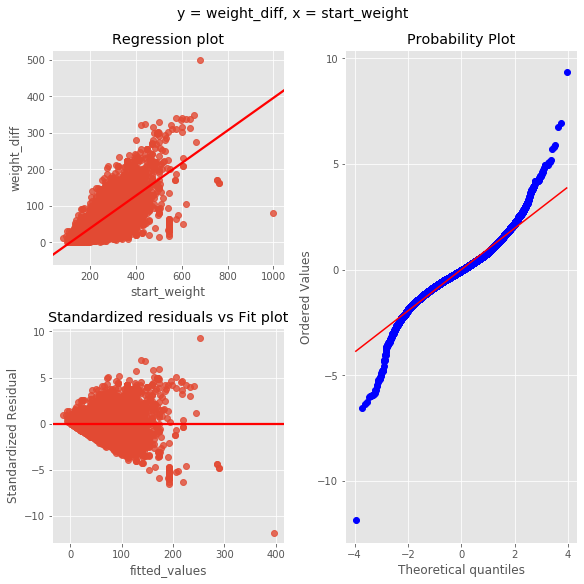

In [28]:
# diagnositic plots for the best feature
fig = lin_regr_diagnostic_plots("weight_diff", "start_weight", pp_data_loss)

In [30]:
fig.savefig("plots/pp_data_start_weight.png")

In [31]:
# simple linear regression with pp_duration_loss
weight_diff_dur_loss = linear_regression("weight_diff", pp_duration_loss, ['norm_rate', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts', 'norm_rate'])

y = weight_diff
excluded features: ['weight_diff', 'norm_rate', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts', 'norm_rate']
df shape: (11190, 15)
X = AGE
                            OLS Regression Results                            
Dep. Variable:            weight_diff   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     336.3
Date:                Thu, 19 Sep 2019   Prob (F-statistic):           4.97e-74
Time:                        11:40:45   Log-Likelihood:                -57099.
No. Observations:               11190   AIC:                         1.142e+05
Df Residuals:                   11188   BIC:                         1.142e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err   

                            OLS Regression Results                            
Dep. Variable:            weight_diff   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     844.7
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          4.17e-179
Time:                        11:40:46   Log-Likelihood:                -56858.
No. Observations:               11190   AIC:                         1.137e+05
Df Residuals:                   11188   BIC:                         1.137e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        43.8907      0.478     91.859

In [32]:
weight_diff_dur_loss

,R-sqr,F-statistic,F-stat p-value,t-test,t-test p-value
start_weight,0.592,16257.9,0.0,127.51,0.0
rate,0.115,1453.7,0.0,38.13,0.0
period_months,0.070,844.7,0.0,29.06,0.0
end_weight,0.063,755.3,0.0,27.48,0.0
height_in,0.058,691.8,0.0,26.30,0.0
sex,0.041,479.2,0.0,-21.89,0.0
age,0.029,336.3,0.0,18.34,0.0


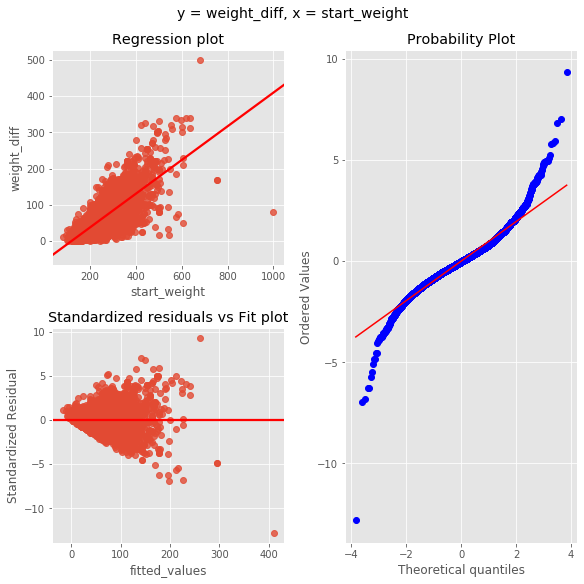

In [33]:
# diagnositic plots for the best two features
fig = lin_regr_diagnostic_plots("weight_diff", "start_weight", pp_duration_loss)

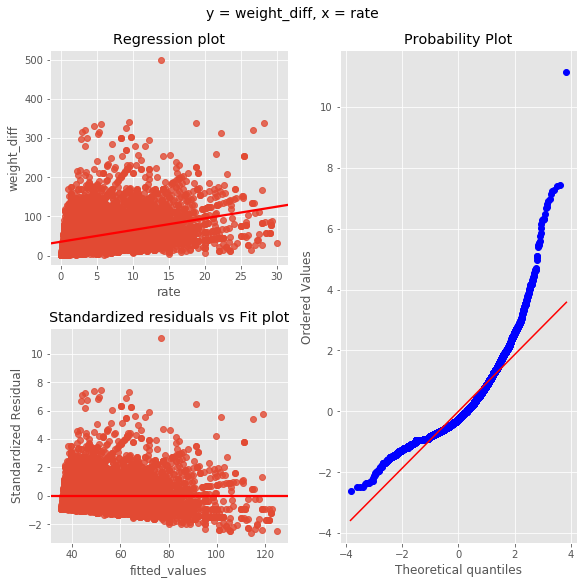

In [34]:
fig = lin_regr_diagnostic_plots("weight_diff", "rate", pp_duration_loss)

The above analysis gives a similar result to what was found previously when both weight loss and weight gain posts were included. The start_weight diagnostic plots look a little worse with more fanning in the residuals vs fit plot.  The rate diagnostic plots are more interpretable, but the linear relationship is less clear, the residuals vs fit plot is not good, and the residuals do not seem normal.  So rate currently does not look like a great variable to include in a linear regression model.  

In [35]:
# add log transformation of start_weight to the df to see if if using the log of start_weight improves the model
pp_data_loss.loc[:, 'log_start_weight'] = np.log(pp_data_loss.loc[:, "start_weight"])

/Users/ajwright/anaconda3/envs/my_conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ajwright/anaconda3/envs/my_conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [36]:
# simple linear regression
weight_diff_loss_log = linear_regression('weight_diff', pp_data_loss, ['score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

y = weight_diff
excluded features: ['weight_diff', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts']
df shape: (18083, 13)
X = AGE
                            OLS Regression Results                            
Dep. Variable:            weight_diff   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     549.3
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          1.10e-119
Time:                        11:41:06   Log-Likelihood:                -92164.
No. Observations:               18083   AIC:                         1.843e+05
Df Residuals:                   18081   BIC:                         1.843e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

                            OLS Regression Results                            
Dep. Variable:            weight_diff   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                 2.092e+04
Date:                Thu, 19 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:41:07   Log-Likelihood:                -85486.
No. Observations:               18083   AIC:                         1.710e+05
Df Residuals:                   18081   BIC:                         1.710e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -534.2736      4.067  

In [37]:
weight_diff_loss_log 

,R-sqr,F-statistic,F-stat p-value,t-test,t-test p-value
start_weight,0.561,23119.0,0.0,152.05,0.0
log_start_weight,0.536,20915.2,0.0,144.62,0.0
height_in,0.051,973.4,0.0,31.20,0.0
end_weight,0.051,963.7,0.0,31.04,0.0
sex,0.039,726.8,0.0,-26.96,0.0
age,0.029,549.3,0.0,23.44,0.0


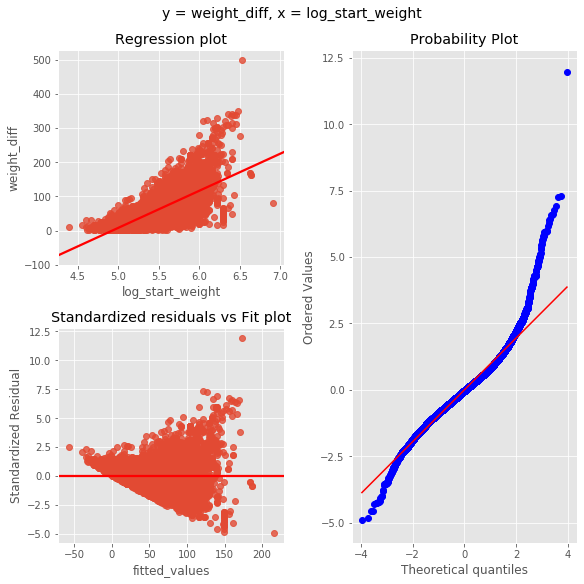

In [38]:
# diagnostic plots of log_start_weight
fig = lin_regr_diagnostic_plots("weight_diff", "log_start_weight", pp_data_loss)

log_start_weight reduces the R-squared score and does not improve the residuals vs fit plot or probability plot.  Stick with start_weight as the best feature. 

In [39]:
# best subsets multiple linear regression using pp_data_loss
weight_diff_loss_step = stepwise_linear_regression("weight_diff", pp_data_loss, ['log_start_weight','end_weight', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

In [40]:
weight_diff_loss_step

,num_predictors,predictors,RSS,rsquared,rsquared_adj,model
0,1,[start_weight],1.279659e+07,0.561140,0.561116,<statsmodels.regression.linear_model.Regressio...
1,2,"[start_weight, height_in]",1.216208e+07,0.582901,0.582855,<statsmodels.regression.linear_model.Regressio...


In [41]:
# best subsets multiple linear regression using pp_data_loss
weight_diff_loss_subset = subset_linear_regression("weight_diff", pp_data_loss, ['log_start_weight', 'end_weight', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

In [42]:
weight_diff_loss_subset

,RSS,model,num_predictors,predictors,rsquared,rsquared_adj
3,1.279659e+07,<statsmodels.regression.linear_model.Regressio...,1,"(start_weight,)",0.561140,0.561116
2,2.766916e+07,<statsmodels.regression.linear_model.Regressio...,1,"(height_in,)",0.051085,0.051032
5,1.216208e+07,<statsmodels.regression.linear_model.Regressio...,2,"(height_in, start_weight)",0.582901,0.582855
4,1.255587e+07,<statsmodels.regression.linear_model.Regressio...,2,"(sex, start_weight)",0.569396,0.569348
3,1.216119e+07,<statsmodels.regression.linear_model.Regressio...,3,"(sex, height_in, start_weight)",0.582931,0.582862
2,1.216206e+07,<statsmodels.regression.linear_model.Regressio...,3,"(age, height_in, start_weight)",0.582902,0.582832


In [43]:
# forward stepwise multiple linear regression using pp_duration_loss
weight_diff_dur_loss_step = stepwise_linear_regression("weight_diff", pp_duration_loss, ['end_weight', 'norm_rate', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

In [44]:
weight_diff_dur_loss_step

,num_predictors,predictors,RSS,rsquared,rsquared_adj,model
0,1,[start_weight],7.441489e+06,0.592362,0.592325,<statsmodels.regression.linear_model.Regressio...
1,2,"[start_weight, period_months]",6.982772e+06,0.617490,0.617422,<statsmodels.regression.linear_model.Regressio...
2,3,"[start_weight, period_months, height_in]",6.644412e+06,0.636025,0.635927,<statsmodels.regression.linear_model.Regressio...
3,4,"[start_weight, period_months, height_in, rate]",6.432446e+06,0.647636,0.647510,<statsmodels.regression.linear_model.Regressio...
4,5,"[start_weight, period_months, height_in, rate,...",6.425169e+06,0.648035,0.647878,<statsmodels.regression.linear_model.Regressio...


In [45]:
# best subsets multiple linear regression using pp_duration_loss
weight_diff_dur_loss_subsets = subset_linear_regression("weight_diff", pp_duration_loss, ['end_weight', 'norm_rate', 'score', 'num_comments', 'month', 'dayofweek', 'NSFW', 'num_posts'])

In [46]:
weight_diff_dur_loss_subsets

,RSS,model,num_predictors,predictors,rsquared,rsquared_adj
3,7.441489e+06,<statsmodels.regression.linear_model.Regressio...,1,"(start_weight,)",0.592362,0.592325
5,1.615587e+07,<statsmodels.regression.linear_model.Regressio...,1,"(rate,)",0.114996,0.114917
12,6.982772e+06,<statsmodels.regression.linear_model.Regressio...,2,"(start_weight, period_months)",0.617490,0.617422
9,7.086253e+06,<statsmodels.regression.linear_model.Regressio...,2,"(height_in, start_weight)",0.611821,0.611752
16,6.644412e+06,<statsmodels.regression.linear_model.Regressio...,3,"(height_in, start_weight, period_months)",0.636025,0.635927
19,6.742424e+06,<statsmodels.regression.linear_model.Regressio...,3,"(start_weight, period_months, rate)",0.630656,0.630557
14,6.432446e+06,<statsmodels.regression.linear_model.Regressio...,4,"(height_in, start_weight, period_months, rate)",0.647636,0.647510
13,6.610102e+06,<statsmodels.regression.linear_model.Regressio...,4,"(sex, start_weight, period_months, rate)",0.637904,0.637775
4,6.425169e+06,<statsmodels.regression.linear_model.Regressio...,5,"(age, height_in, start_weight, period_months, ...",0.648035,0.647878
5,6.432446e+06,<statsmodels.regression.linear_model.Regressio...,5,"(sex, height_in, start_weight, period_months, ...",0.647636,0.647479


For weight loss only, start_weight alone still seems to be the best feature to include in a model that might be used to predict how much weight someone will lose. 